In [27]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import os
import requests
import tqdm
import json
import pandas as pd
import numpy as np
import zipfile
from collections import Counter

In [29]:
file_id = '1yXvDTRRxjCLyAf4icU1sEMKF0NpssCnC'
destination = 'human_proteins.tsv'
hf_name = "t5-small"
max_length = 512
tokenizer_folder = "PROTNAME_tok"
save_folder = "PROTNAME"
vocab_size=32

In [30]:
file_id = '1yXvDTRRxjCLyAf4icU1sEMKF0NpssCnC'
destination = 'human_proteins.tsv'

def format_size(value):
  if value >= 1024**3:
    return f"{round(value / 1024**3 , 3)} GB"
  elif value >= 1024**2:
    return f"{round(value / 1024**2 , 3)} MB"
  elif value >= 1024:
    return f"{round(value / 1024 , 3)} KB"
  return f"{value} B"

# Code taken from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    params = { 'id' : id, 'confirm' : 1 }
    response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    pb = tqdm.tqdm(response.iter_content(CHUNK_SIZE))
    b_total = 0
    with open(destination, "wb") as f:
        for i,chunk in enumerate(pb):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                b_total += len(chunk)

                if i % 1000 == 0:
                  pb.set_description(f"written : {format_size(b_total)}")
                i += 1
    print("\n")
    print(f"saved all the data to {destination}. total size : {format_size(os.stat(destination).st_size)}")


download_file_from_google_drive(file_id, destination)

written : 32.0 KB: : 413it [00:01, 382.18it/s]



saved all the data to human_proteins.tsv. total size : 12.9 MB


In [33]:
dataframe = pd.read_csv("human_proteins.tsv", sep="\t")

In [143]:
dataframe = dataframe[dataframe["Sequence"].str.len() <= 510]

In [144]:
with open("Sequences.txt", "w") as f:
    f.write("\n".join(dataframe["Sequence"].values))

In [145]:
with open("names.txt", "w") as f:
    f.write("\n".join([v.split("(")[0].strip() for v in dataframe["Protein Name"].values]))

In [146]:
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# Train the input tokenizer 
input_tokenizer = ByteLevelBPETokenizer()
input_tokenizer.train(files=["Sequences.txt"], vocab_size=261, 
                      special_tokens=["<pad>", "<s>", "</s>","<unk>"])

input_tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", input_tokenizer.token_to_id("</s>")),
    ("<s>", input_tokenizer.token_to_id("<s>")),
)

# save the input tokenizer 
os.makedirs("input_tokenizer_aminoacids", exist_ok=True)
input_tokenizer.save_model("input_tokenizer_aminoacids")

['input_tokenizer_aminoacids/vocab.json',
 'input_tokenizer_aminoacids/merges.txt']

In [147]:
input_tokenizer.encode("MRWQEMGYIFYPRKLR").type_ids

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [148]:
# Train the output tokenizer 
from tokenizers import SentencePieceBPETokenizer

output_tokenizer = SentencePieceBPETokenizer()
output_tokenizer.train(files=["names.txt"], vocab_size=32000,min_frequency=2, special_tokens=["<pad>","<s>","</s>","<unk>"])

# save the input tokenizer 
os.makedirs("output_tokenizer_names", exist_ok=True)
input_tokenizer.save_model("output_tokenizer_names")

['output_tokenizer_names/vocab.json', 'output_tokenizer_names/merges.txt']

In [149]:
e = output_tokenizer.encode("Protein FAM170A")

In [150]:
import torch 
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

class CustomAADataset(Dataset):
  def __init__(self, data, input_tokenizer, output_tokenizer, max_length=512):
    self.data = data
    self.input_tokenizer = PreTrainedTokenizerFast(tokenizer_object=input_tokenizer,
                                                   max_length=512,
                                                   padding=True)
    self._input_tokenizer = input_tokenizer
 
    self.output_tokenizer = PreTrainedTokenizerFast(tokenizer_object=output_tokenizer,
                                                   max_length=512,
                                                   padding=True)
    self._output_tokenizer = output_tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    source_text = self.data["source"][idx]
    target_text = self.data["target"][idx]

    # Tokenize and truncate input and output texts 
    input_tokens = self.input_tokenizer.encode(source_text)
    output_tokens = self.output_tokenizer.encode(target_text)

    # Pad input and output tokens
    input_tokens = input_tokens + [self._input_tokenizer.token_to_id("<pad>")] * (self.max_length - len(input_tokens))

    output_tokens = output_tokens + [self._output_tokenizer.token_to_id("<pad>")] * (self.max_length - len(output_tokens))

    return {"input_ids": torch.tensor(input_tokens, dtype=torch.long),
            "labels": torch.tensor(output_tokens, dtype=torch.long),
            }


In [151]:
# Load data
from datasets import Dataset as Dataset_hf

dataset = Dataset_hf.from_dict({"source": dataframe["Sequence"].values, "target": dataframe["Protein Name"].values})

(array([ 107.,  722., 1567., 1451., 1429., 1408., 1952., 1425., 1295.,
        1261.]),
 array([  2. ,  52.8, 103.6, 154.4, 205.2, 256. , 306.8, 357.6, 408.4,
        459.2, 510. ]),
 <BarContainer object of 10 artists>)

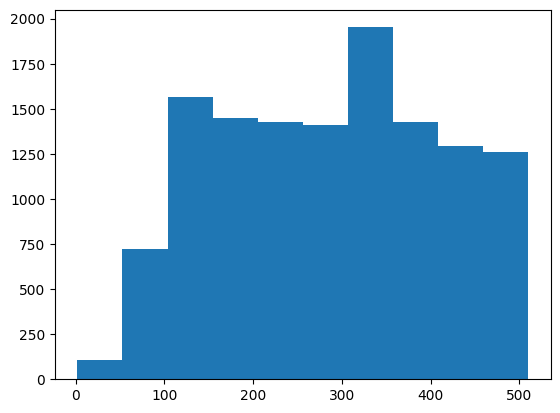

In [154]:
import matplotlib.pyplot as plt
plt.hist(dataframe["Sequence"].str.len())

In [155]:
# Create dataset instances
train_dataset = CustomAADataset(dataset, input_tokenizer, output_tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
from transformers import T5ForConditionalGeneration, T5Config, AdamW
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load T5 model
config = T5Config.from_pretrained("t5-small")
model = T5ForConditionalGeneration(config)
model.to(device)

# Set hyperparameters
num_epochs = 3
learning_rate = 5e-4

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}/{num_epochs}")

    # Training
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f"Train loss: {sum(train_losses) / len(train_losses)}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_t5")


Epoch: 1/3


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/198 [00:00<?, ?it/s]

torch.Size([64, 512])
torch.Size([64, 512])
